In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [2]:
path = "census-income.data"
df = pd.read_csv(path, header=None)

columns = [
    "age",
    "class_of_worker",
    "detailed_industry_recode",
    "detailed_occupation_recode",
    "education",
    "wage_per_hour",
    "enroll_in_edu_inst_last_wk",
    "marital_stat",
    "major_industry_code",
    "major_occupation_code",
    "race",
    "hispanic_origin",
    "sex",
    "member_of_a_labor_union",
    "reason_for_unemployment",
    "full_or_part_time_employment_stat",
    "capital_gains",
    "capital_losses",
    "dividends_from_stocks",
    "tax_filer_stat",
    "region_of_previous_residence",
    "state_of_previous_residence",
    "detailed_household_and_family_stat",
    "detailed_household_summary_in_household",
    "instance_weight",
    "migration_code_change_in_msa",
    "migration_code_change_in_reg",
    "migration_code_move_within_reg",
    "live_in_this_house_1_year_ago",
    "migration_prev_res_in_sunbelt",
    "num_persons_worked_for_employer",
    "family_members_under_18",
    "country_of_birth_father",
    "country_of_birth_mother",
    "country_of_birth_self",
    "citizenship",
    "own_business_or_self_employed",
    "fill_inc_questionnaire_for_veterans_admin",
    "veterans_benefits",
    "weeks_worked_in_year",
    "year",
    "income"
]

df.columns = columns

df.shape

(199523, 42)

In [3]:
leakage_cols = [ "instance_weight"]
df = df.drop(columns=leakage_cols)

In [4]:
obj_cols = df.select_dtypes(include="object").columns
df[obj_cols] = df[obj_cols].apply(lambda s: s.str.strip())

df = df.replace("?", np.nan)
missing_report = df.isna().sum().sort_values(ascending=False)
print(missing_report.head(15))

migration_code_change_in_msa               99696
migration_code_change_in_reg               99696
migration_code_move_within_reg             99696
migration_prev_res_in_sunbelt              99696
country_of_birth_father                     6713
country_of_birth_mother                     6119
country_of_birth_self                       3393
state_of_previous_residence                  708
num_persons_worked_for_employer                0
detailed_household_summary_in_household        0
live_in_this_house_1_year_ago                  0
age                                            0
family_members_under_18                        0
citizenship                                    0
own_business_or_self_employed                  0
dtype: int64


In [5]:
print("Any literal '?' left?", (df.astype(str) == "?").any().any())


Any literal '?' left? False


In [6]:
income_clean = df["income"].astype(str).str.strip().str.replace(".", "", regex=False)
y = np.where(income_clean.eq("50000+"), 1,np.where(income_clean.eq("- 50000"), 0, np.nan))

print("income value counts (raw):")
print(df["income"].value_counts(dropna=False).head(10))
print("\nincome value counts (clean):")
print(pd.Series(income_clean).value_counts(dropna=False))
print("\nMissing y:", int(np.isnan(y).sum()))

income value counts (raw):
- 50000.    187141
50000+.      12382
Name: income, dtype: int64

income value counts (clean):
- 50000    187141
50000+      12382
Name: income, dtype: int64

Missing y: 0


In [7]:
X = df.drop(columns=["income"])
mask = ~np.isnan(y)
X = X.loc[mask].copy()
y = y[mask].astype(int)
print("X shape:", X.shape, "y shape:", y.shape)
print("positive rate:", np.nanmean(y))

X shape: (199523, 40) y shape: (199523,)
positive rate: 0.06205800834991455


In [8]:
numeric_features = X.select_dtypes(include=["int64","float64"]).columns.tolist()

for col in ["detailed_industry_recode", "detailed_occupation_recode"]:
    if col in numeric_features:
        numeric_features.remove(col)

categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

categorical_features += ["detailed_industry_recode", "detailed_occupation_recode"]


In [9]:
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_transformer,numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

model = LogisticRegression(max_iter=300, class_weight="balanced", solver="saga")

clf = Pipeline([
    ("preprocess", preprocess),
    ("model", model)
])

In [10]:
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
scoring = {"roc_auc": "roc_auc","pr_auc": "average_precision"}

cv_results = cross_validate(clf,X,y,cv=cv,scoring=scoring,n_jobs=-1)

print("Cross-Validation Results (5-Fold)")
print("ROC-AUC mean:", cv_results["test_roc_auc"].mean())
print("ROC-AUC std :", cv_results["test_roc_auc"].std())
print("PR-AUC mean :", cv_results["test_pr_auc"].mean())
print("PR-AUC std  :", cv_results["test_pr_auc"].std())


Cross-Validation Results (5-Fold)
ROC-AUC mean: 0.9448917613768902
ROC-AUC std : 0.0006564177334885395
PR-AUC mean : 0.6081222646821617
PR-AUC std  : 0.006417939402170465


In [11]:
X_train,X_test,y_train,y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nReport:\n", classification_report(y_test, y_pred, digits=3))

C:\Users\moham\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


ROC-AUC: 0.9470494345977873
Confusion matrix:
 [[31945  5484]
 [  252  2224]]

Report:
               precision    recall  f1-score   support

           0      0.992     0.853     0.918     37429
           1      0.289     0.898     0.437      2476

    accuracy                          0.856     39905
   macro avg      0.640     0.876     0.677     39905
weighted avg      0.949     0.856     0.888     39905



In [12]:
preprocess = clf.named_steps["preprocess"]
model = clf.named_steps["model"]

num_feature_names = np.array(numeric_features).astype(str)

cat_ohe = preprocess.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = cat_ohe.get_feature_names_out(np.array(categorical_features).astype(str))

feature_names = np.concatenate([num_feature_names, cat_feature_names])


coefs = model.coef_.ravel()

coef_df = pd.DataFrame({"feature": feature_names,"coef": coefs,"abs_coef": np.abs(coefs)})
 
coef_df_sorted = coef_df.sort_values("abs_coef", ascending=False)

top_pos = coef_df.sort_values("coef", ascending=False).head(10)
top_neg = coef_df.sort_values("coef", ascending=True).head(10)

print("Top 10 Positive (increase P(income>50K)):")
print(top_pos[["feature","coef"]].to_string(index=False))

print("\nTop 10 Negative (decrease P(income>50K)):")
print(top_neg[["feature","coef"]].to_string(index=False))

print("\nTop 20 by absolute coefficient:")
print(coef_df_sorted.head(20)[["feature","coef","abs_coef"]].to_string(index=False))



Top 10 Positive (increase P(income>50K)):
                                                                   feature     coef
                                       education_Doctorate degree(PhD EdD) 2.217393
                          education_Prof school degree (MD DDS DVM LLB JD) 1.766086
                          education_Masters degree(MA MS MEng MEd MSW MBA) 1.593232
                                            country_of_birth_self_Scotland 1.553790
                                               detailed_industry_recode_20 1.375636
                                               detailed_industry_recode_26 1.298548
                                 state_of_previous_residence_Massachusetts 1.023554
                                               detailed_industry_recode_13 1.022296
detailed_household_and_family_stat_Other Rel 18+ ever marr RP of subfamily 0.957568
                                      education_Bachelors degree(BA AB BS) 0.941890

Top 10 Negative (decrease P(incom

In [13]:
candidate_thresholds = [0.3, 0.5, 0.7, 0.85]
for thr in candidate_thresholds:
    y_pred_thr = (y_proba >= thr).astype(int)

    print(f"\n=== Threshold = {thr} ===")
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_thr))
    print(classification_report(y_test, y_pred_thr, digits=3))


=== Threshold = 0.3 ===
Confusion matrix:
 [[28743  8686]
 [  126  2350]]
              precision    recall  f1-score   support

           0      0.996     0.768     0.867     37429
           1      0.213     0.949     0.348      2476

    accuracy                          0.779     39905
   macro avg      0.604     0.859     0.607     39905
weighted avg      0.947     0.779     0.835     39905


=== Threshold = 0.5 ===
Confusion matrix:
 [[31945  5484]
 [  252  2224]]
              precision    recall  f1-score   support

           0      0.992     0.853     0.918     37429
           1      0.289     0.898     0.437      2476

    accuracy                          0.856     39905
   macro avg      0.640     0.876     0.677     39905
weighted avg      0.949     0.856     0.888     39905


=== Threshold = 0.7 ===
Confusion matrix:
 [[34545  2884]
 [  532  1944]]
              precision    recall  f1-score   support

           0      0.985     0.923     0.953     37429
           1

In [14]:
FINAL_THRESHOLD = 0.85

y_pred_final = (y_proba >= FINAL_THRESHOLD).astype(int)

print("FINAL_THRESHOLD:", FINAL_THRESHOLD)
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC (Average Precision):", average_precision_score(y_test, y_proba))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_final))
print("\nReport:\n", classification_report(y_test, y_pred_final, digits=3))

FINAL_THRESHOLD: 0.85
ROC-AUC: 0.9470494345977873
PR-AUC (Average Precision): 0.6135478714972453
Confusion matrix:
 [[36200  1229]
 [  954  1522]]

Report:
               precision    recall  f1-score   support

           0      0.974     0.967     0.971     37429
           1      0.553     0.615     0.582      2476

    accuracy                          0.945     39905
   macro avg      0.764     0.791     0.777     39905
weighted avg      0.948     0.945     0.947     39905



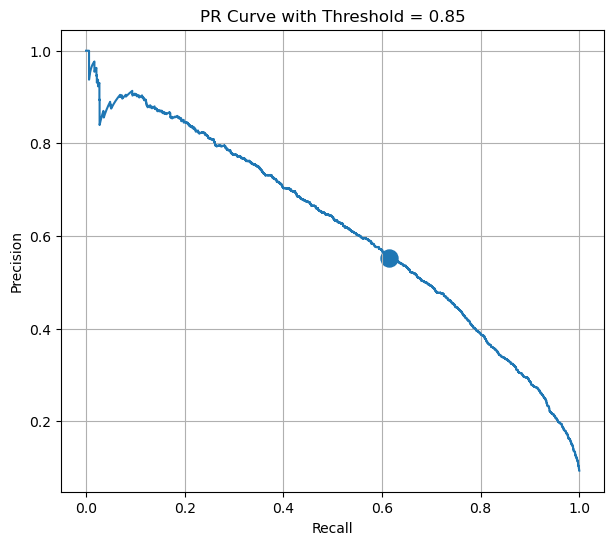

Precision at 0.85: 0.5530523255813954
Recall at 0.85: 0.6147011308562197


In [15]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

thr = 0.85
idx = np.argmin(np.abs(thresholds - thr))

plt.figure(figsize=(7,6))
plt.plot(recall, precision)
plt.scatter(recall[idx], precision[idx], s=150)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve with Threshold = 0.85")
plt.grid(True)
plt.show()

print("Precision at 0.85:", precision[idx])
print("Recall at 0.85:", recall[idx])


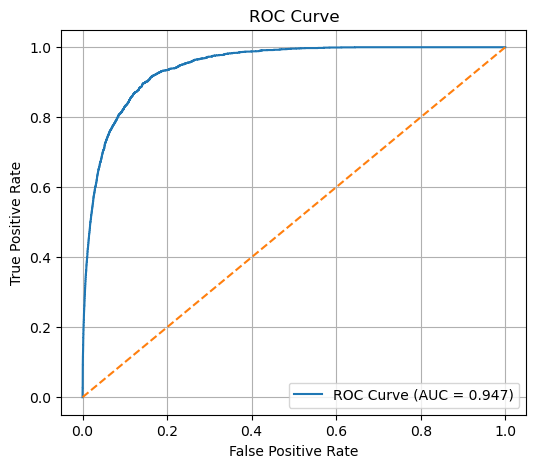

In [16]:
fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()